https://cxc.cfa.harvard.edu/csc/why/var_test_comparison.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_dd
from scipy.stats import ks_2samp

In [2]:
def lc_from_toa(toa, toa_val, N_bins):
    statistic, bin_edges, binnumber = binned_statistic_dd(sample=toa,
                                                          values=toa_val,
                                                          statistic='count',
                                                          bins=N_bins)
    
    time  = bin_edges[0][:-1]
    value = statistic
    return time, value

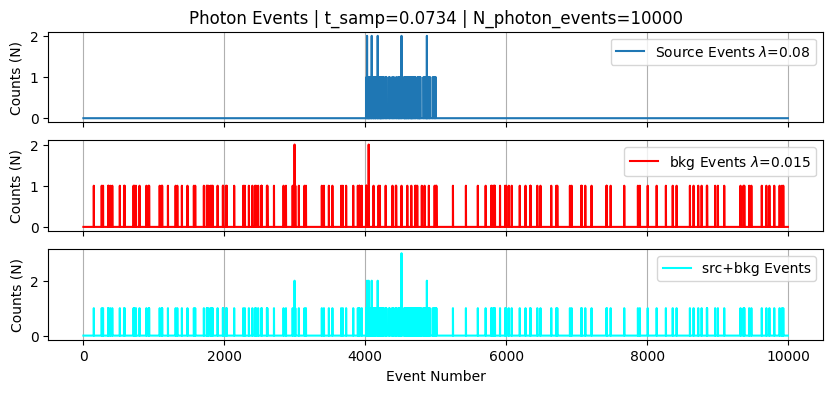

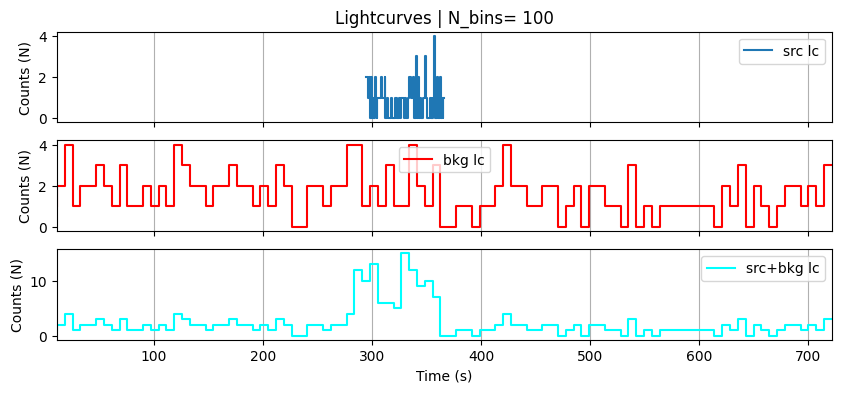

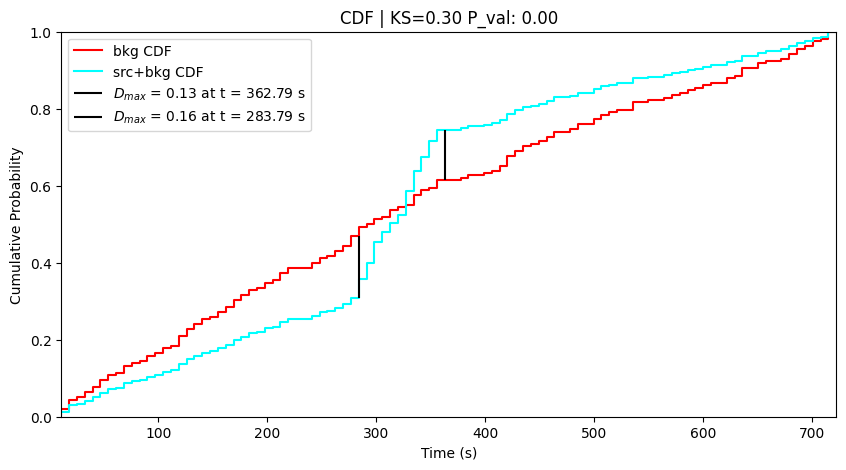

KS Statistic: 0.30
P-value: 0.00


In [3]:
#np.random.seed(42)
N_photon_events = 10000 # Number of Poission Samples (Number of Photon Events)

t_samp  = 73.4e-3 # XMM Full frame Sample Time (see https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/uhb/epicmode.html)
N_bins  = 100     # Binning Interval for creating lightcurves


src_mean_rate = 0.08  # Source Mean Count Rate
bkg_mean_rate = 0.015 # Bkg Mean Count Rate

# Get the event times for each photon event (or non event)
evt_time = np.arange(0, t_samp*N_photon_events, t_samp)

# Simulate event arrivals
evt_bkg     = np.random.poisson(lam=bkg_mean_rate, size=N_photon_events)
evt_src     = np.random.poisson(lam=src_mean_rate, size=N_photon_events)

# Mask out start and end to create an artificial burst

# Single Burst
evt_src[:4000] = 0 
evt_src[5000:] = 0

# Double Burst
#evt_src[:4000] = 0 
#evt_src[5000:6000] = 0
#vt_src[7000:] = 0

# Combine src and bkg
evt_src_bkg = evt_src + evt_bkg

# Plot event lists
fig, ax = plt.subplots(3,1, figsize=(10,4), sharex=True)
ax[0].set_title(f'Photon Events | t_samp={t_samp} | N_photon_events={N_photon_events}')
ax[0].plot(evt_src, label=fr'Source Events $\lambda$={src_mean_rate}')
ax[1].plot(evt_bkg, label=fr'bkg Events $\lambda$={bkg_mean_rate}', color='red')
ax[2].plot(evt_src_bkg, label='src+bkg Events', color='cyan')

for a in ax:
    a.legend()
    a.set_ylabel('Counts (N)')
    a.grid(axis='x')
ax[2].set_xlabel('Event Number')    

# Get Time of Arrivals
toa_src     = evt_time[evt_src>0]
toa_bkg     = evt_time[evt_bkg>0]
toa_src_bkg = evt_time[evt_src_bkg>0]

# Get the values of time of arrivals (was it 1, 2, etc..)
toa_src_val     = evt_src[evt_src>0]
toa_bkg_val     = evt_bkg[evt_bkg>0]
toa_src_bkg_val = evt_src_bkg[evt_src_bkg>0]

# Create Binned Lightcurves
lc_src_time, lc_src_val         = lc_from_toa(toa_src, toa_src_val, N_bins=N_bins)
lc_bkg_time, lc_bkg_val         = lc_from_toa(toa_bkg, toa_bkg_val, N_bins=N_bins)
lc_src_bkg_time, lc_src_bkg_val = lc_from_toa(toa_src_bkg, toa_src_bkg_val, N_bins=N_bins)

# Plot Lightcurves
fig, ax = plt.subplots(3,1, figsize=(10,4), sharex=True)
ax[0].set_title(f'Lightcurves | N_bins= {N_bins}')
ax[0].step(lc_src_time, lc_src_val, label='src lc')
ax[1].step(lc_bkg_time, lc_bkg_val, label='bkg lc', color='red')
ax[2].step(lc_src_bkg_time, lc_src_bkg_val, label='src+bkg lc', color='cyan')

for a in ax:
    a.legend()
    a.set_ylabel('Counts (N)')
    a.grid(axis='x')
    a.set_xlim()
ax[2].set_xlabel('Time (s)')
ax[2].set_xlim(min(lc_bkg_time), max(lc_bkg_time))


# Perform KS test
ks_statistic, ks_p_value = ks_2samp(lc_src_val, lc_bkg_val)

# Compute CDFs
cdf_bkg = np.cumsum(lc_bkg_val) / np.sum(lc_bkg_val)
cdf_src_bkg = np.cumsum(lc_src_bkg_val) / np.sum(lc_src_bkg_val)

# Plot CDFs
fig, ax = plt.subplots(figsize=(10, 5))
ax.step(lc_bkg_time, cdf_bkg, label='bkg CDF', color='red')
ax.step(lc_src_bkg_time, cdf_src_bkg, label='src+bkg CDF', color='cyan')


# Calculate and plot the maximum difference D_max
# Truncate the line at the min and max values of the CDFs
cdf_diff       = cdf_src_bkg - cdf_bkg
max_diff       = np.max(cdf_diff)
max_diff_idx   = np.argmax(cdf_diff)
max_diff_time  = lc_src_bkg_time[max_diff_idx]
min_y          = np.min([cdf_bkg[max_diff_idx], cdf_src_bkg[max_diff_idx]])
max_y          = np.max([cdf_bkg[max_diff_idx], cdf_src_bkg[max_diff_idx]])
ax.vlines(x=max_diff_time, ymin=min_y, ymax=max_y, color='black', linestyle='-', 
           label=fr'$D_{{max}}$ = {max_diff:.2f} at t = {max_diff_time:.2f} s')

# Now do the same and plot the other difference D_2
# This is used for the Kupier Statistic
cdf_diff       = cdf_bkg - cdf_src_bkg
max_diff       = np.max(cdf_diff)
max_diff_idx   = np.argmax(cdf_diff)
max_diff_time  = lc_src_bkg_time[max_diff_idx]
min_y          = np.min([cdf_bkg[max_diff_idx], cdf_src_bkg[max_diff_idx]])
max_y          = np.max([cdf_bkg[max_diff_idx], cdf_src_bkg[max_diff_idx]])
ax.vlines(x=max_diff_time, ymin=min_y, ymax=max_y, color='black', linestyle='-', 
           label=fr'$D_{{max}}$ = {max_diff:.2f} at t = {max_diff_time:.2f} s')




ax.legend()
ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Time (s)')
ax.set_ylim(0,1)
ax.set_xlim(min(lc_bkg_time), max(lc_bkg_time))


ax.set_title(f'CDF | KS={ks_statistic:.2f} P_val: {ks_p_value:.2f}')
plt.show()

# Print KS test results
print(f'KS Statistic: {ks_statistic:.2f}')
print(f'P-value: {ks_p_value:.2f}')